# University of Kentucky Daily Crime Log

The University of Kentucky provides publically available information on crimes commited on campus property.
The following process is the extraction, analysis, and visualization of the data.

## Scraping the Data

In [1]:
# Import the support libraries
from os import getenv
import requests
from bs4 import BeautifulSoup
import pandas as pd
from dateutil.parser import parser
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# we are going to scrape crime data from the UK crime http://www.uky.edu/crimelog/
# substitute variables to fill in REST query criteria
start_month, start_day, start_year = 1, 1, 2019
end_month, end_day, end_year = 12, 31, 2019
crime_data_raw = requests.get('http://www.uky.edu/crimelog/log?field_log_category_value=All' +
                              '&field_log_report_value%5Bmin%5D%5Bmonth%5D=' + str(start_month) +
                              '&field_log_report_value%5Bmin%5D%5Bday%5D=' + str(start_day) +
                              '&field_log_report_value%5Bmin%5D%5Byear%5D=' + str(start_year) +
                              '&field_log_report_value%5Bmax%5D%5Bmonth%5D=' + str(end_month) +
                              '&field_log_report_value%5Bmax%5D%5Bday%5D=' + str(end_day) +
                              '&field_log_report_value%5Bmax%5D%5Byear%5D=' + str(end_year)
                             )

In [4]:
# create a soup object 
crime_bs_proc = BeautifulSoup((crime_data_raw.text), "html.parser")

## Processing the Data

In [5]:
# find the table header in the data
crime_data_header = crime_bs_proc.find('thead')

In [6]:
# find all the table headers
crime_data_heads = crime_data_header.find_all('th')

In [7]:
# create an empty list for the header
header = []

# iterate through the header element to get text
for col in crime_data_heads:
    cols = col.find_all('a')
    cols = [ele.text.strip() for ele in cols]
    header.append([ele for ele in cols if ele])

# flatten the list to a single list
header = [item for sublist in header for item in sublist]


In [8]:
# find the table rows in the data
crime_data_body = crime_bs_proc.find('tbody')

In [9]:
# find all table rows
crime_data_rows = crime_data_body.find_all('tr')

In [10]:
# create an empty list for the rows of data
data = []

# iterate through the header element to get the rows
for row in crime_data_rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])


In [11]:
# create a dataframe with our data using our header list
uk_crime_data = pd.DataFrame(data, columns=header)
uk_crime_data.head()

,Category,Case number,Crime date and time,Report date,Location,Incident Description,Residential occurrence,Disposition
0,Drug Violations,201911190010-01,11/19/2019 - 1:22am,11/19/2019,SOUTH LIMESTON STREET/CONN TERRACE,POSSESSION OF CONTROLLED SUBSTANCE; POSSESSION...,No,Open
1,Drug Violations,201911190002-02,11/19/2019 - 12:17am,11/19/2019,329 SOUTH MARTIN LUTHER KING BOULEVARD - BOYD ...,POSSESSION OF MARIJUANA,No,Closed
2,Harassment,CSA20191296,11/19/2019 - 10:05pm,11/19/2019,1350 BULL LEA ROAD - EASTERN STATE HOSPITAL,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA
3,All Other Offenses,201911190084-01,11/19/2019 - 10:39pm,11/19/2019,LEXINGTON AVENUE/EAST MAXWELL STREET,"FLEEING OR EVADING POLICE, 2ND DEGREE MOTOR VE...",No,Open
4,Theft,201911190041-01,11/18/2019 - 4:00pm,11/19/2019,"703 SPORTS CENTER DRIVE - WOODLAND GLEN IV, BI...",THEFT BY UNLAWFUL TAKING BICYCLES $500 OR MORE...,No,Closed


In [12]:
# backup the raw scraped data to CSV file
uk_crime_data.to_csv('data/ukpd_crimelog_2018.csv', index=False)

## Structuring the Data

In [13]:
# create a new dataframe from the CSV
uk_crime_csv = pd.read_csv('data/ukpd_crimelog_2018.csv')
uk_crime_csv.head()

,Category,Case number,Crime date and time,Report date,Location,Incident Description,Residential occurrence,Disposition
0,Drug Violations,201911190010-01,11/19/2019 - 1:22am,11/19/2019,SOUTH LIMESTON STREET/CONN TERRACE,POSSESSION OF CONTROLLED SUBSTANCE; POSSESSION...,No,Open
1,Drug Violations,201911190002-02,11/19/2019 - 12:17am,11/19/2019,329 SOUTH MARTIN LUTHER KING BOULEVARD - BOYD ...,POSSESSION OF MARIJUANA,No,Closed
2,Harassment,CSA20191296,11/19/2019 - 10:05pm,11/19/2019,1350 BULL LEA ROAD - EASTERN STATE HOSPITAL,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA
3,All Other Offenses,201911190084-01,11/19/2019 - 10:39pm,11/19/2019,LEXINGTON AVENUE/EAST MAXWELL STREET,"FLEEING OR EVADING POLICE, 2ND DEGREE MOTOR VE...",No,Open
4,Theft,201911190041-01,11/18/2019 - 4:00pm,11/19/2019,"703 SPORTS CENTER DRIVE - WOODLAND GLEN IV, BI...",THEFT BY UNLAWFUL TAKING BICYCLES $500 OR MORE...,No,Closed


In [14]:
# descriptive statistical summary
uk_crime_csv.describe()

,Category,Case number,Crime date and time,Report date,Location,Incident Description,Residential occurrence,Disposition
count,553,553,553,553,553,553,553,553
unique,19,553,526,60,169,198,2,8
top,Theft,201909260006,11/16/2019 - 7:02pm,10/25/2019,1350 BULL LEA ROAD - EASTERN STATE HOSPITAL,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA
freq,115,1,2,21,128,39,407,261


In [15]:
uk_crime_csv['Street'] = [i[0] for i in (uk_crime_csv.Location.apply(lambda x: x.split(' - ')))]
uk_crime_csv['Area'] = [i[-1] for i in (uk_crime_csv.Location.apply(lambda x: x.split(' - ')))]

In [16]:
del uk_crime_csv['Location']

In [17]:
uk_crime_csv.head()

,Category,Case number,Crime date and time,Report date,Incident Description,Residential occurrence,Disposition,Street,Area
0,Drug Violations,201911190010-01,11/19/2019 - 1:22am,11/19/2019,POSSESSION OF CONTROLLED SUBSTANCE; POSSESSION...,No,Open,SOUTH LIMESTON STREET/CONN TERRACE,SOUTH LIMESTON STREET/CONN TERRACE
1,Drug Violations,201911190002-02,11/19/2019 - 12:17am,11/19/2019,POSSESSION OF MARIJUANA,No,Closed,329 SOUTH MARTIN LUTHER KING BOULEVARD,"BOYD HALL, OUTSIDE"
2,Harassment,CSA20191296,11/19/2019 - 10:05pm,11/19/2019,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA,1350 BULL LEA ROAD,EASTERN STATE HOSPITAL
3,All Other Offenses,201911190084-01,11/19/2019 - 10:39pm,11/19/2019,"FLEEING OR EVADING POLICE, 2ND DEGREE MOTOR VE...",No,Open,LEXINGTON AVENUE/EAST MAXWELL STREET,LEXINGTON AVENUE/EAST MAXWELL STREET
4,Theft,201911190041-01,11/18/2019 - 4:00pm,11/19/2019,THEFT BY UNLAWFUL TAKING BICYCLES $500 OR MORE...,No,Closed,703 SPORTS CENTER DRIVE,"WOODLAND GLEN IV, BIKE RACK"


In [18]:
uk_crime_csv['Street'] = uk_crime_csv.Street.apply(lambda x: x + ', LEXINGTON, KY')

In [19]:
uk_crime_csv.head()

,Category,Case number,Crime date and time,Report date,Incident Description,Residential occurrence,Disposition,Street,Area
0,Drug Violations,201911190010-01,11/19/2019 - 1:22am,11/19/2019,POSSESSION OF CONTROLLED SUBSTANCE; POSSESSION...,No,Open,"SOUTH LIMESTON STREET/CONN TERRACE, LEXINGTON, KY",SOUTH LIMESTON STREET/CONN TERRACE
1,Drug Violations,201911190002-02,11/19/2019 - 12:17am,11/19/2019,POSSESSION OF MARIJUANA,No,Closed,"329 SOUTH MARTIN LUTHER KING BOULEVARD, LEXING...","BOYD HALL, OUTSIDE"
2,Harassment,CSA20191296,11/19/2019 - 10:05pm,11/19/2019,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA,"1350 BULL LEA ROAD, LEXINGTON, KY",EASTERN STATE HOSPITAL
3,All Other Offenses,201911190084-01,11/19/2019 - 10:39pm,11/19/2019,"FLEEING OR EVADING POLICE, 2ND DEGREE MOTOR VE...",No,Open,"LEXINGTON AVENUE/EAST MAXWELL STREET, LEXINGTO...",LEXINGTON AVENUE/EAST MAXWELL STREET
4,Theft,201911190041-01,11/18/2019 - 4:00pm,11/19/2019,THEFT BY UNLAWFUL TAKING BICYCLES $500 OR MORE...,No,Closed,"703 SPORTS CENTER DRIVE, LEXINGTON, KY","WOODLAND GLEN IV, BIKE RACK"


In [20]:
# backup the raw scraped data to CSV file
uk_crime_csv.to_csv('data/ukpd_crimelog_2018_geo.csv', index=False)

## Geocoding the Data

In [21]:
uk_crime_geo = pd.read_csv('data/ukpd_crimelog_2018_geo.csv')
uk_crime_geo.head()

,Category,Case number,Crime date and time,Report date,Incident Description,Residential occurrence,Disposition,Street,Area
0,Drug Violations,201911190010-01,11/19/2019 - 1:22am,11/19/2019,POSSESSION OF CONTROLLED SUBSTANCE; POSSESSION...,No,Open,"SOUTH LIMESTON STREET/CONN TERRACE, LEXINGTON, KY",SOUTH LIMESTON STREET/CONN TERRACE
1,Drug Violations,201911190002-02,11/19/2019 - 12:17am,11/19/2019,POSSESSION OF MARIJUANA,No,Closed,"329 SOUTH MARTIN LUTHER KING BOULEVARD, LEXING...","BOYD HALL, OUTSIDE"
2,Harassment,CSA20191296,11/19/2019 - 10:05pm,11/19/2019,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA,"1350 BULL LEA ROAD, LEXINGTON, KY",EASTERN STATE HOSPITAL
3,All Other Offenses,201911190084-01,11/19/2019 - 10:39pm,11/19/2019,"FLEEING OR EVADING POLICE, 2ND DEGREE MOTOR VE...",No,Open,"LEXINGTON AVENUE/EAST MAXWELL STREET, LEXINGTO...",LEXINGTON AVENUE/EAST MAXWELL STREET
4,Theft,201911190041-01,11/18/2019 - 4:00pm,11/19/2019,THEFT BY UNLAWFUL TAKING BICYCLES $500 OR MORE...,No,Closed,"703 SPORTS CENTER DRIVE, LEXINGTON, KY","WOODLAND GLEN IV, BIKE RACK"


In [22]:
unique_locations = list(uk_crime_geo.Street.unique())

In [23]:
unique_locations

['SOUTH LIMESTON STREET/CONN TERRACE, LEXINGTON, KY',
 '329 SOUTH MARTIN LUTHER KING BOULEVARD, LEXINGTON, KY',
 '1350 BULL LEA ROAD, LEXINGTON, KY',
 'LEXINGTON AVENUE/EAST MAXWELL STREET, LEXINGTON, KY',
 '703 SPORTS CENTER DRIVE, LEXINGTON, KY',
 '720 WOODLAND AVENUE, LEXINGTON, KY',
 '1120 UNIVERSITY DRIVE, LEXINGTON, KY',
 '344 SOUTH MARTIN LUTHER KING BOULEVARD, LEXINGTON, KY',
 '411 SOUTH LIMESTONE STREET, LEXINGTON, KY',
 '111 AVENUE OF CHAMPIONS/LIMESTONE STREET, LEXINGTON, KY',
 '330 SOUTH LIMESTONE STREET, LEXINGTON, KY',
 '310 SOUTH LIMESTONE STREET, LEXINGTON, KY',
 '125 AVENUE OF CHAMPIONS, LEXINGTON, KY',
 '444 COLUMBIA AVENUE, LEXINGTON, KY',
 'ON CAMPUS, LEXINGTON, KY',
 '140 PATTERSON DRIVE, LEXINGTON, KY',
 '326 SOUTH MARTIN LUTHER KING BOULEVARD, LEXINGTON, KY',
 'SOUTH LIMESTONE STREET/EAST HIGH STREET, LEXINGTON, KY',
 '705 SPORTS CENTER DRIVE, LEXINGTON, KY',
 '1000 SOUTH LIMESTONE STREET, LEXINGTON, KY',
 '685 SPORTS CENTER DRIVE, LEXINGTON, KY',
 'EUCLID AVENUE

### Still to finish

In [7]:
#import the geocoder API (you'll need an api key)
from geopy.geocoders import OpenCage
geolocator = OpenCage(api_key='')

In [8]:
geolocator.geocode('1120 UNIVERSITY DRIVE, LEXINGTON, KY')

Location(Lewis Hall, 1120 University Drive, Lexington, KY 40526, United States of America, (38.0314545, -84.5030904, 0.0))

In [ ]:
street_locs = [geolocator.geocode(i) for i in uk_crime_geo.Street]
#locs = pd.DataFrame([(i, i.latitude, i.longitude) for i in street_locs], columns=['Location', 'Latitude', 'Longitude'])
#streets_geocoded = uk_crime_geo.combine_first(locs)

## Time Series Analysis

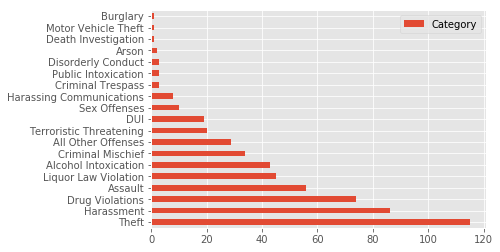

In [24]:
# plot the number of crime categories in 2018
category_summary = pd.DataFrame(uk_crime_csv.Category.value_counts())
category_summary.plot(kind='barh')

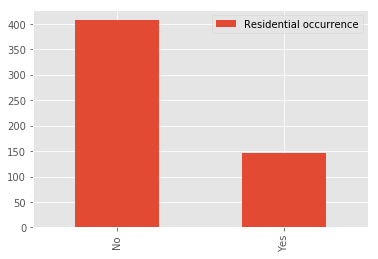

In [25]:
# plot the number of residential occurences in 2018
residential_summary = pd.DataFrame(uk_crime_csv['Residential occurrence'].value_counts())
residential_summary.plot(kind='bar')

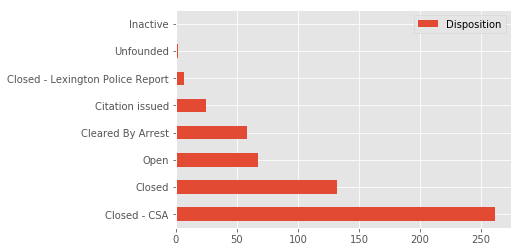

In [26]:
# plot the number of crime case outcomes in 2018
disposition_summary = pd.DataFrame(uk_crime_csv.Disposition.value_counts())
disposition_summary.plot(kind='barh')

In [27]:
# import data with datetime group as index
uk_crime_datetime = pd.read_csv('data/ukpd_crimelog_2018.csv', index_col='Crime date and time', parse_dates=True)

In [28]:
uk_crime_datetime.head()

,Category,Case number,Report date,Location,Incident Description,Residential occurrence,Disposition
Crime date and time,,,,,,,
2019-11-19 01:22:00,Drug Violations,201911190010-01,11/19/2019,SOUTH LIMESTON STREET/CONN TERRACE,POSSESSION OF CONTROLLED SUBSTANCE; POSSESSION...,No,Open
2019-11-19 00:17:00,Drug Violations,201911190002-02,11/19/2019,329 SOUTH MARTIN LUTHER KING BOULEVARD - BOYD ...,POSSESSION OF MARIJUANA,No,Closed
2019-11-19 22:05:00,Harassment,CSA20191296,11/19/2019,1350 BULL LEA ROAD - EASTERN STATE HOSPITAL,HARASSMENT-PHYSICAL CONTACT-NO INJURY,No,Closed - CSA
2019-11-19 22:39:00,All Other Offenses,201911190084-01,11/19/2019,LEXINGTON AVENUE/EAST MAXWELL STREET,"FLEEING OR EVADING POLICE, 2ND DEGREE MOTOR VE...",No,Open
2019-11-18 16:00:00,Theft,201911190041-01,11/19/2019,"703 SPORTS CENTER DRIVE - WOODLAND GLEN IV, BI...",THEFT BY UNLAWFUL TAKING BICYCLES $500 OR MORE...,No,Closed
